# Time-Domain FLIM & MSSR Simulator

## Overview
This notebook simulates *Time-Domain Fluorescence Lifetime Imaging Microscopy (TD-FLIM)* datasets to demonstrate the generation of fluorescence signals, their spatial distribution, and the application of *Mean Shift Super Resolution (MSSR)*.

The workflow consists of:
1. **Temporal Simulation**: Generating ideal time-correlated single-photon counting (TCSPC) signals for specific lifetimes.
2. **Spatial Construction**: Placing fluorophores in a 3D $(x, y, t)$ grid.
3. **Optical Blurring**: Simulating diffraction limits using a Point Spread Function (PSF).
4. **Super-Resolution**: Applying MSSR to enhance spatial resolution and analyzing the resulting lifetimes.
## Physical Model
The simulation assumes a multi-exponential fluorescence decay in the time domain:

$$I(t) = \sum_{i} \alpha_i e^{-t/\tau_i} + \text{background}$$

Where:
* $\tau_i$ is the fluorescence lifetime of the $i$-th component.
* $\alpha_i$ is the amplitude (fractional intensity).
* $t$ is the time delay after the excitation pulse.

In [36]:
# Install Libraries
print("Installing necessary libraries...")
!pip install numpy
!pip install phasorpy > /dev/null 2>&1
!pip install ptufile > /dev/null 2>&1
!pip install PyQt5 > /dev/null 2>&1
!pip install napari[all] > /dev/null 2>&1
!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
!pip install cmcrameri
print("Libraries installed successfully.")


Installing necessary libraries...
Libraries installed successfully.


In [37]:
# Import required modules and functions
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_ptu
from phasorpy.phasor import phasor_from_signal, phasor_threshold
from phasorpy.lifetime import phasor_from_lifetime, lifetime_to_signal, phasor_calibrate
from phasorpy.plot import PhasorPlot, plot_phasor_image, plot_signal_image

import numpy as np
import scipy.signal
from matplotlib import pyplot
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Import MSSR class for super-resolution processing
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()
import cmcrameri.cm as cmc

In [38]:
def format_plot(ax):
    """
    Standardizes plot aesthetics for publication-quality figures.
    """
    # Font sizes
    title_size = 16
    axtitles = 14
    ticksize = 12

    # Apply formatting if elements exist
    if ax.get_title():
        ax.title.set_fontsize(title_size)
    if ax.get_xlabel():
        ax.xaxis.label.set_fontsize(axtitles)
    if ax.get_ylabel():
        ax.yaxis.label.set_fontsize(axtitles)
    ax.tick_params(axis='both', labelsize=ticksize)

## Simulation Parameters

Here we define the *Temporal Physics* (lifetimes, frequency) and the *Spatial Optics* (pixel size, PSF).

* **Lifetimes**: We simulate two distinct species ($\tau_1=1.0$ ns and $\tau_2=4.0$ ns).
* **Frequency**: 80 MHz, creating a repetition period of 12.5 ns.
* **Optics**: `sigma_nm` defines the extent of the diffraction blur (Gaussian PSF).
* **Resolution Limits**: `cx_1` and `cx_2` define the separation distance, tested against Rayleigh and Sparrow limits.

In [39]:
# Define common parameters used throughout the simulation:

## Temporal parameters
tau_1 = 1
tau_2 = 4
lifetimes = [tau_1, tau_2]  # lifetime in ns

frequency = 80.0  # fundamental frequency in MHz
period = (1 / frequency) * 1e3 # period of fundamental frequency in ns
reference_lifetime = 0.06  # lifetime of reference signal in ns (Instrument Response function approximation)

settings = {
    'samples': 256,  # number of time bins per period
    'mean': 1e4,  # average intensity (photon count)
    'background': 0.0,  # no signal from background
    'zero_phase': 0.08,  # phase offset for the IRF peak
    'zero_stdev': None,  # standard deviation of IRF in radians
}

## Spatial parameters
pxsz = 5                                             # Pixel size in nm

# Optics (Diffraction limit simulation)
sigma_nm = 100                                       # PSF sigma in nanometers. Equivalent to a FWHM of ~235 nm
sigma_px = int(sigma_nm / pxsz)                      # PSF sigma converted to pixels

# Image Dimensions
x_dim = y_dim = 127                                  # Image Size in pixels
center = np.ceil(x_dim/2).astype(int)
cy = center

# MSSR limit distance (Commented out options for testing)
#cx_1 = int(center - 0.8*sigma_px)
#cx_2 = int(center + 0.8*sigma_px)

# Sparrow limit distance (Currently active)
cx_1 = center - sigma_px
cx_2 = center + sigma_px

# Visualization parameters
color = 'PRGn' #'cmc.batlowK'
legendtitles = '16'

## Temporal Signal Synthesis

Before creating images, we simulate the raw Time-Domain (TD) signals for the specific lifetimes defined above.

The function `lifetime_to_signal` generates the expected photon counts over time bins based on the exponential decay model:
$$ I(t) \propto e^{-t/\tau} $$

In [40]:
## Time-domain, single-exponential signal generation
# To synthesize separate signals for each lifetime component at once, we pass the list of lifetimes.
# The 'settings' dictionary controls sampling rate and noise.

signal, _, times = lifetime_to_signal(frequency, lifetimes, **settings)
reference_signal, _, _ = lifetime_to_signal(frequency, reference_lifetime, **settings)

# Extract individual signals for clarity
signal_1 = signal[0] # Signal corresponding to tau_1
signal_2 = signal[1] # Signal corresponding to tau_2

## Spatio-Temporal Image Simulation

We now construct the full 3D data stack $I(x, y, t)$.

* Initialize empty 3D arrays (`F1xy`, `F2xy`).
* Place the temporal signal for $\tau_2$ at position `cx_1`.
* Place the temporal signal for $\tau_1$ at position `cx_2`.

Initially, these are *point sources* (single pixels) with no optical blurring.

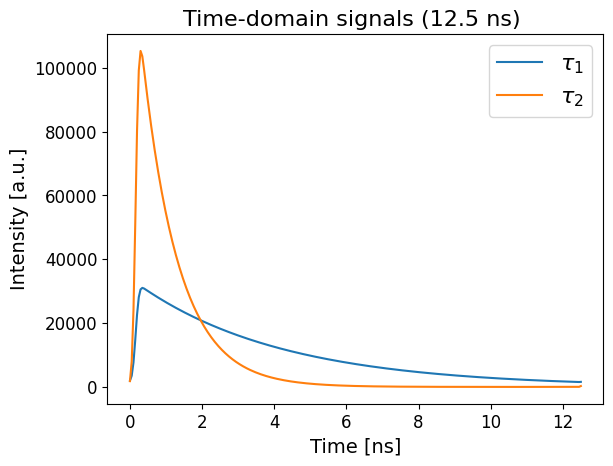

In [41]:
##### Create a TD emission x,y,t stack for each fluorophore
t_dim = settings['samples']

# Create fluorescence data stacks initialized to zero (y, x, t)
F1xy = np.zeros((y_dim, x_dim, t_dim))
F2xy = np.zeros((y_dim, x_dim, t_dim))

# Assign the temporal signal to the specific spatial pixel (creating a point source)
# Note: signal.T has shape (samples, components), so we index appropriately
F1xy[cy, cx_1, :] = signal.T[:,1] # Left fluorophore with tau_2
F2xy[cy, cx_2, :] = signal.T[:,0] # Right fluorophore with tau_1

# Create figure and axis to verify the temporal placement
fig, ax = plt.subplots()

# Define the title, labels, and formatting
ax.set(
    title=f'Time-domain signals ({period} ns) ',
    xlabel='Time [ns]',
    ylabel='Intensity [a.u.]',
)

# Plot fluorophore signals to verify decay profiles
ax.plot(times, F1xy[cy, cx_1, :], label='$\\tau_1$')
ax.plot(times, F2xy[cy, cx_2, :], label='$\\tau_2$')

# Apply standard formatting
format_plot(ax)

# Add legend
ax.legend(loc=1, fontsize=legendtitles)

# Display the plot
plt.show()

## Simulating Optical Blurring (Diffraction)

Real microscopy images are blurred by the diffraction limit of the optical system. We simulate this by convolving our "ideal" point sources with a *Point Spread Function (PSF)*.

$$ I_{convolved}(x,y,t) = I_{source}(x,y,t) \ast PSF(x,y) $$

This operation mixes the signals spatially. Pixels between the two fluorophores will now contain a mixture of $\tau_1$ and $\tau_2$, creating a challenge for resolving them.

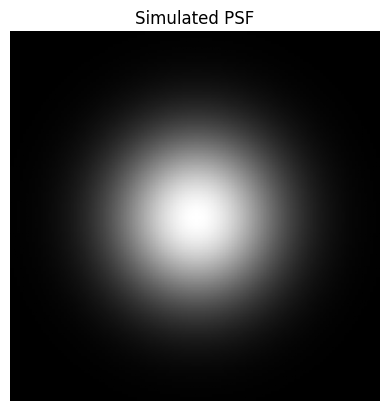

In [42]:
# Define a 2D Gaussian function to serve as the Point Spread Function (PSF)
def gaussian_psf(size, sigma):
    """Generates a 2D Gaussian PSF."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf /= np.sum(psf)  # Normalize so total energy is conserved
    return psf

# Generate the PSF based on the sigma_px calculated in Section 2
sigma_psf = sigma_px
PSF = gaussian_psf(x_dim, sigma_psf)

# Visualize the PSF
plt.imshow(PSF, cmap="gray")
plt.title("Simulated PSF")
plt.axis('off')
plt.show()

In [43]:
# Convolve the data stacks with the PSF to simulate optical blurring
# We use fftconvolve for efficiency on large arrays.
# The 'same' mode ensures the output has the same dimensions as the input.

# Initialize arrays for convolved data
F1xy_convolved = np.empty_like(F1xy)
F2xy_convolved = np.empty_like(F2xy)

# Iterate through each time bin (frame) and convolve with the spatial PSF
for t in range(t_dim):
    F1xy_convolved[:, :, t] = scipy.signal.fftconvolve(F1xy[:, :, t], PSF, mode='same')
    F2xy_convolved[:, :, t] = scipy.signal.fftconvolve(F2xy[:, :, t], PSF, mode='same')

# Combine the two fluorophore signals into a single "measured" image stack
# This represents the raw data recorded by the detector
FD_FLIM_img = F1xy_convolved + F2xy_convolved

print("Convolution complete.")

Convolution complete.


In [44]:
# Create an empty 3D array to hold the reference signal for each pixel
# Dimensions: x_dim x y_dim x t_dim (spatial x, spatial y, time)
img_reference_signal = np.zeros((x_dim, y_dim, t_dim))

# Fill the 3D array with the reference signal for each pixel
for x in range(img_reference_signal.shape[0]):
    for y in range(img_reference_signal.shape[1]):
        # Assign the reference time-domain signal to the (x, y) pixel
        img_reference_signal[x, y, :] = reference_signal

# Compute phasor components from the reference signal for each pixel
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)

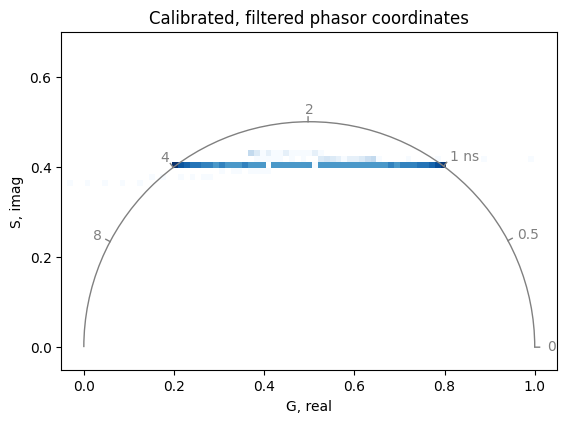

In [45]:
# Combine the two convolved FLIM signals into a single time-domain FLIM signal
# TD_FLIM_signal has the same dimensions as F1xy_convolved and F2xy_convolved: (x, y, t)
TD_FLIM_signal = F1xy_convolved + F2xy_convolved

# Compute phasor components (mean, real, imaginary) along the time axis (axis=2)
# This is the main analysis used in the Sparrow workflow
mean_spa, real_spa, imag_spa = phasor_from_signal(TD_FLIM_signal, axis=2)

# Calibrate the phasor coordinates using the reference signal
real_spa, imag_spa = phasor_calibrate(
    real_spa, imag_spa,
    img_reference_mean, img_reference_real, img_reference_imag,
    frequency=frequency, lifetime=reference_lifetime
)

# Create a phasor plot for the calibrated Sparrow phasor coordinates
phasorplot = PhasorPlot(
    frequency=frequency,
    title='Calibrated, filtered phasor coordinates'
)

# Plot the 2D histogram of the phasor coordinates
phasorplot.hist2d(real_spa, imag_spa, bins=85)


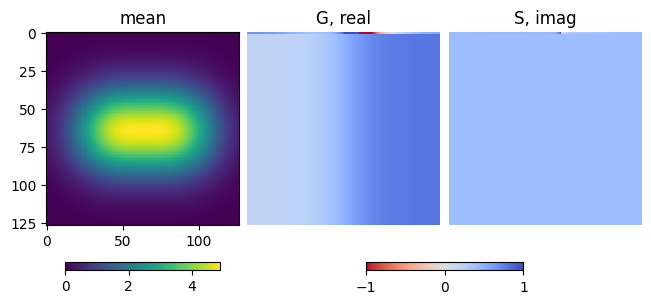

In [46]:
# Visualize the phasor information as an image
plot_phasor_image(mean_spa, real_spa, imag_spa)

## Mean Shift Super Resolution (MSSR)

We now apply the **MSSR** algorithm to the diffraction-limited data. MSSR is a computational technique that enhances spatial resolution by analyzing the local curvature of fluorescence intensity.

**Workflow:**
1.  *Sum Intensity:* Create a 2D intensity projection (summing over time).
2.  *Run MSSR:* Apply the `mssr_instance.run_mssr` function to sharpen the spatial features.
3.  *Temporal Reassignment:* Use the sharpened MSSR image as a mask/guide to re-assign the time-domain signals to their super-resolved locations.

In [47]:
# Parameters for MSSR sharpening
fwhm = 2.35 * sigma_px   # Full Width at Half Maximum (approx. Gaussian width in pixels)
amp = 1                   # Amplitude of MSSR filter
order = 1                 # Order of MSSR
mesh = True               # Optional: meshgrid used for spatial convolution
ftI = False               # Optional: use Fourier Transform for intensity? Default is False
intNorm = False           # Optional: normalize intensity? Default is True

progress: 100%|██████████| 49/49 [00:01<00:00, 42.10it/s]


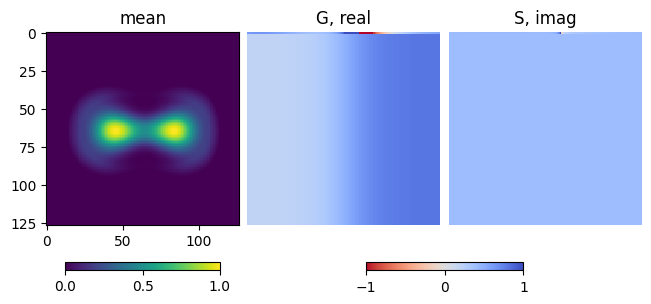

In [48]:
# Apply MSSR to the mean Sparrow image
# sfMSSR is a method of mssr_instance that performs MSSR filtering
mean_spa_mssr1 = mssr_instance.sfMSSR(
    img=mean_spa,
    fwhm=fwhm,
    amp=amp,
    order=order,
    mesh=mesh,
    ftI=ftI,
    intNorm=intNorm
)

# Plot the phasor image using the MSSR-sharpened mean image
# real_spa and imag_spa are the phasor coordinates of the Sparrow method
plot_phasor_image(mean_spa_mssr1, real_spa, imag_spa)

### Thresholding the MSSR-sharpened image

phasor_threshold removes low-intensity pixels (below `mean_min`) to focus on meaningful fluorescence signal only.
This step is applied separately for Sparrow and Multi-Species analysis.

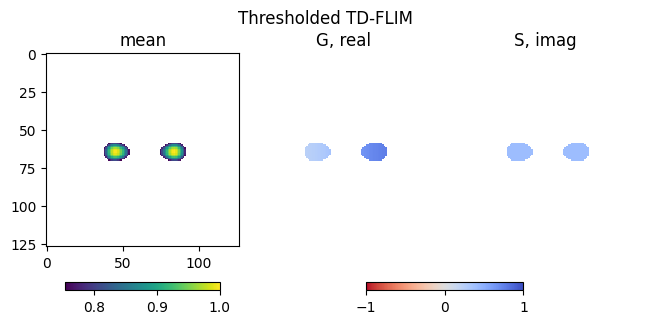

In [49]:
# %% [code]
# Threshold the MSSR-sharpened Sparrow image
mean_th_spa, real_th_spa, imag_th_spa = phasor_threshold(
    mean_spa_mssr1,  # MSSR-sharpened mean image
    real_spa,        # Sparrow phasor real component
    imag_spa,        # Sparrow phasor imaginary component
    mean_min=0.75    # Minimum mean intensity threshold
)

# Plot the thresholded phasor image
plot_phasor_image(mean_th_spa, real_th_spa, imag_th_spa, title='Thresholded TD-FLIM')

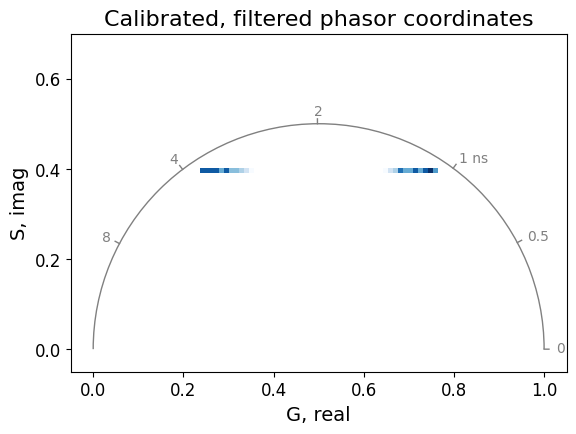

In [50]:
# 2D histogram of calibrated phasor coordinates
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_spa, imag_th_spa, bins=100)
format_plot(phasorplot.ax)

Calculate laser period for TD-FLIM image mapping

The laser period T (in ns) is needed to convert phasor coordinates into modulation and phase lifetimes.

In [51]:
T = (1 / frequency) * 1e3  # Convert frequency to laser period in ns
laser_period_in_seconds = T * 1e-9  # Convert ns to seconds for TD-FLIM calculations

### Generate TD-FLIM images from phasor coordinates

The function td_flim_figure computes:
* Modulation (mod) and Phase (phi)
* Modulation lifetime (tau_m) and Phase lifetime (tau_p)
* Corrected G and S phasor components (G_corr, S_corr) and produces a figure of TD-FLIM maps with modulation and phase data.


In [52]:
def td_flim_figure(G,S,laser_period_in_seconds, harmonic = 1, mod_correction = True,
                   mod_lower_limit = 0.1, phase_correction = True, phase_lower_limit = 0.1,
                   tau_m_correction = True, factor_tm = 1, tau_p_correction = True,
                   factor_tp = 1, num_bins = 100, color = color, plotit=True,):
    from matplotlib.ticker import FormatStrFormatter
    # A function to calculate the modulation, phase delay, modulation lifetimes and phase lifetimes
    #i.e. the TD-FLIM image it also contaains the instructions for plotting the results
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano
    # Setting epsilon to avoid division by zero
    epsilon = np.nan

    G = np.where(G > 0, G, epsilon)
    S = np.where(S > 0, S, epsilon)

    mod = np.sqrt(G**2 + S**2)
    phi = np.arctan2(S,G)

    mod_min = 1 / np.sqrt((1 + (w_nano*tau_2)**2))
    mod_max = 1 / np.sqrt((1 + (w_nano*tau_1)**2))

    phi_max = np.arctan(w_nano*tau_2)
    phi_min = np.arctan(w_nano*tau_1)

    #Corrections
    #Mod correction
    if mod_correction:
        mod = np.where(mod >= mod_lower_limit, mod, epsilon)

    tau_m = (1 / w) * np.sqrt(np.maximum((1/(mod**2))-1,0))
    tau_m = tau_m*1e9   #to show in nanoseconds

    #Phase correction
    quarter_pi = np.arctan(1)
    phi[phi==quarter_pi] = epsilon

    if phase_correction:
        upper_limit = np.min([np.pi - phase_lower_limit, np.max(phi)-np.max(phi) * 0.01])  # Define your upper threshold
        phi = np.where((phase_lower_limit <= phi) & (phi <= upper_limit), phi, epsilon)

    tau_p = (1 / w) * (np.tan(phi))
    tau_p = tau_p*1e9       #to show in nanoseconds

    #tau_p correction
    if tau_p_correction:
        tau_p = np.where(tau_p <= (T_nano/factor_tp), tau_p, epsilon)
        tau_p_label = f'ns (/{factor_tp})'
    else:
        tau_p[tau_p > T_nano] = epsilon
        tau_p_label = 'ns'

    #tau_mod correction
    if tau_m_correction:
        tau_m = np.where(tau_m <= (T_nano/factor_tm), tau_m, epsilon)
        tau_m_label = f'ns (/{factor_tm})'
    else:
        tau_m[tau_m > T_nano] = epsilon
        tau_m_label = 'ns'

    # G and S correction
    if mod_correction or phase_correction:
        G_corr = mod * np.cos(phi)
        S_corr = mod * np.sin(phi)

    elif tau_m_correction or tau_p_correction:
        w_nano = (2 * np.pi) / T_nano
        G_corr = np.sqrt(1 / (((w_nano * tau_m)**2 + 1) * ((w_nano * tau_p)**2 + 1)))
        G_corr = np.where(G_corr < 1, G_corr, epsilon)
        S_corr = w_nano * tau_p * G_corr

    else:
        G_corr = G
        S_corr = S

    if plotit:
      #Output figure

      color = color
      titlesize = 20
      suptitle = 22
      axsize = 18
      ticksize = 16
      legsize = 16
      s = 400
      color_1 = 'y' #360f5a
      color_2 = 'r'
      color_3 = 'k'

      ##Images of TD_FLIM and the phasor plot
      f, ax = plt.subplots(2,2, figsize = (8.5,8.5))

      #Modulation Map
      im00 = ax[0,0].imshow(mod, cmap=color, vmin = mod_min, vmax= mod_max)
      # Scatter plots
      ax[0,0].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s, label = 'position of $\u03c4_1$')
      ax[0,0].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s, label = 'position of $\u03c4_2$')
      ax[0,0].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s, label = 'position of $\u03c4_{sp}$')
      ax[0,0].axis('off')
      ax[0,0].set_title('Modulation Map', fontsize=titlesize)
      cbar00 = f.colorbar(im00, ax = ax[0,0], fraction=0.046, pad=0.04)
      cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      cbar00.set_label('a.u.', fontsize=axsize)
      cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
      ax[0,0].legend(bbox_to_anchor=(1.4, -0.23), loc='lower center', ncol=3, fontsize = legsize) #-0.2
      #ax[0,0].set_box_aspect(1)

      #Phase Map
      im01 = ax[0,1].imshow(phi, cmap=color, vmin= phi_min, vmax=phi_max)
      # Scatter plots
      ax[0,1].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
      ax[0,1].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s)
      ax[0,1].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s)
      ax[0,1].axis('off')
      ax[0,1].set_title('Phase Map', fontsize=titlesize)
      cbar01 = f.colorbar(im01, ax = ax[0,1], fraction=0.046, pad=0.04)
      cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      cbar01.set_label('radians', fontsize=axsize)
      cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
      #ax[0,1].set_box_aspect(1)

      #Tau_m Map
      im10 = ax[1,0].imshow(tau_m, cmap=color, vmin = tau_1, vmax=tau_2)
      # Scatter plots
      ax[1,0].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
      ax[1,0].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s)
      ax[1,0].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s)
      ax[1,0].axis('off')
      ax[1,0].set_title('Modulation Lifetime, $\u03c4_M$', fontsize=titlesize)
      cbar10 = f.colorbar(im10, ax = ax[1,0], fraction=0.046, pad=0.04)
      cbar10.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
      cbar10.set_label(tau_m_label, fontsize=axsize)
      cbar10.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
      #ax[1,0].set_box_aspect(1)

      #Tau_p Map
      im11 = ax[1,1].imshow(tau_p, cmap=color, vmin = tau_1, vmax=tau_2)
      # Scatter plots
      ax[1,1].scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
      ax[1,1].scatter(cx_2, center, color=color_2, linewidth=2.5, marker='+', s=s)
      ax[1,1].scatter(center, center, color=color_3, linewidth=2.5, marker='+', s=s)
      ax[1,1].axis('off')
      ax[1,1].set_title('Phase Lifetime, $\u03c4_{\u03C6}$', fontsize=titlesize)
      cbar11 = f.colorbar(im11, ax = ax[1,1], fraction=0.046, pad=0.04)
      cbar11.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
      cbar11.set_label(tau_p_label, fontsize=axsize)
      cbar11.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
      #ax[1,1].set_box_aspect(1)

      f.suptitle('TD-FLIM images',x=0.55, y=0.99, fontsize = suptitle)
      f.subplots_adjust(wspace=0.3, hspace=0.35, top=0.87, bottom=0.1, left=0.05, right=0.95)
      plt.show()

    else:
      f = None

    return mod, tau_m, phi, tau_p, G_corr, S_corr, f

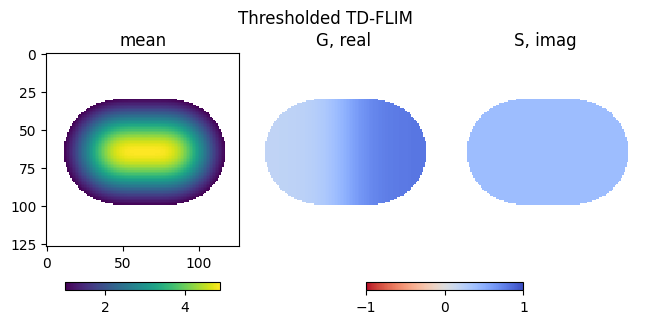

In [53]:
# TD-FLIM figure of thresholded Sparrow image
mod_lower_limit = 0.36
phase_lower_limit = 0.1
factor_tm = 1
factor_tp = 1
bins = 100
color = 'PRGn'

# Threshold the raw Sparrow mean image (before MSSR) for comparison
mean_th_spa_r, real_th_spa_r, imag_th_spa_r = phasor_threshold(
    mean_spa, real_spa, imag_spa, mean_min=1
)

# Plot thresholded phasor image
plot_phasor_image(mean_th_spa_r, real_th_spa_r, imag_th_spa_r, title='Thresholded TD-FLIM')

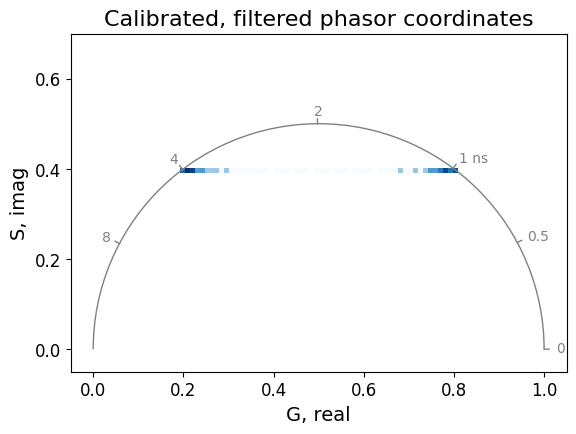

In [54]:
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_spa_r, imag_th_spa_r, bins = 100)
format_plot(phasorplot.ax)

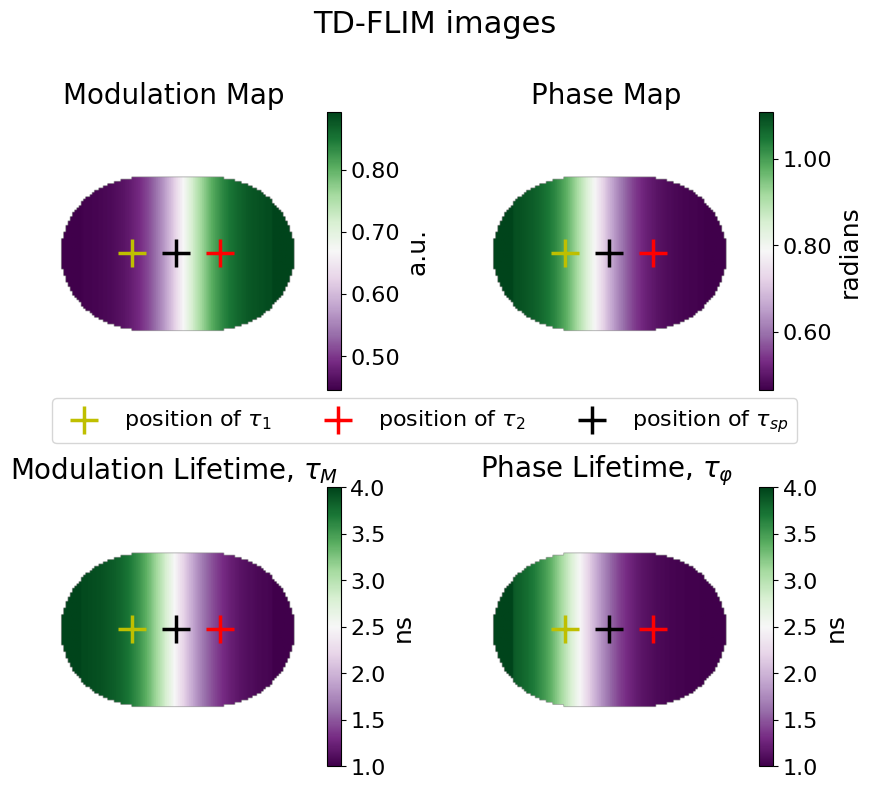

In [20]:
# Create the TD-FLIM figure
mod_spa, tau_m_spa, phase_spa, tau_p_spa, _, _, f = td_flim_figure(
    G=real_th_spa_r, S=imag_th_spa_r,
    laser_period_in_seconds=laser_period_in_seconds,
    harmonic=1,
    mod_correction=False,
    mod_lower_limit=mod_lower_limit,
    phase_correction=False,
    phase_lower_limit=phase_lower_limit,
    tau_m_correction=False,
    factor_tm=factor_tm,
    tau_p_correction=False,
    factor_tp=factor_tp,
    num_bins=30,
    color=color
)

Setting up all the key parameters for TD-FLIM. Calculate the laser period and defines thresholds and correction factors for lifetime analysis.

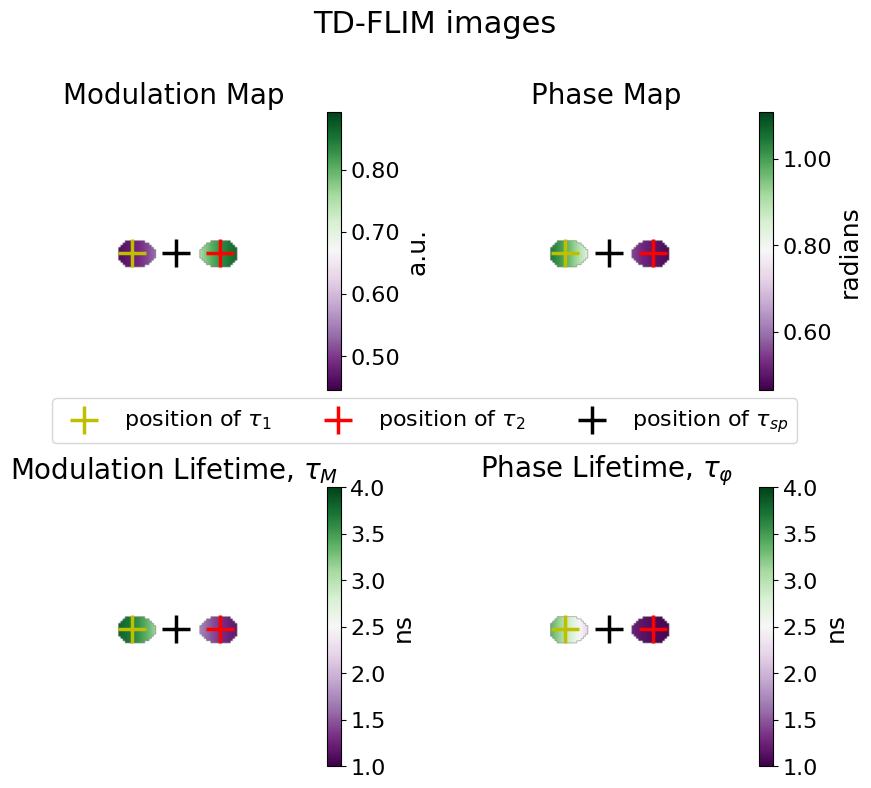

In [21]:
# Parameters for TD-FLIM figure

# Laser period in ns, calculated from modulation frequency (frequency variable must be defined elsewhere)
T = (1 / frequency) * 1e3

# Convert laser period to seconds
laser_period_in_seconds = T * 1e-9

# Threshold limits for modulation and phase in TD-FLIM calculations
mod_lower_limit = 0.36
phase_lower_limit = 0.1

# Correction factors for lifetime calculations
factor_tm = 1  # Factor for modulation lifetime (tau_m)
factor_tp = 1  # Factor for phase lifetime (tau_p)

# Histogram bins for TD-FLIM plots
bins = 100

# Color map for plots
color = 'PRGn'

# TD-FLIM calculation for Sparrow dataset
# Returns modulation (mod_th_spa), modulation lifetime (tau_m_th_spa), phase (phase_th_spa),
# phase lifetime (tau_p_th_spa), and the last output is unused (_)
mod_th_spa, tau_m_th_spa, phase_th_spa, tau_p_th_spa, _, _, f = td_flim_figure(
    real_th_spa,
    imag_th_spa,
    laser_period_in_seconds,
    harmonic = 1,
    mod_correction = False,
    mod_lower_limit = mod_lower_limit,
    phase_correction = False,
    phase_lower_limit = phase_lower_limit,
    tau_m_correction = False,
    factor_tm = factor_tm,
    tau_p_correction = False,
    factor_tp = factor_tp,
    num_bins = 30,
    color = color
)


In [22]:
# Import Required Modules
import matplotlib.pyplot as plt

# Import phasorpy tools for plotting and analysis
from phasorpy.color import CATEGORICAL
from phasorpy.cursor import (
    mask_from_circular_cursor,
    mask_from_elliptic_cursor,
    mask_from_polar_cursor,
    pseudo_color,
)
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_lsm
from phasorpy.phasor import phasor_from_signal, phasor_threshold
from phasorpy.plot import PhasorPlot

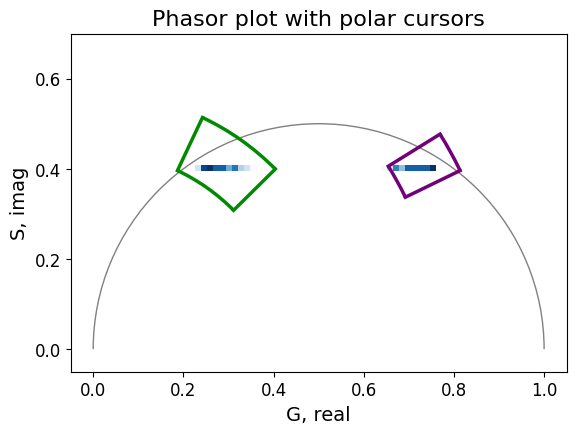

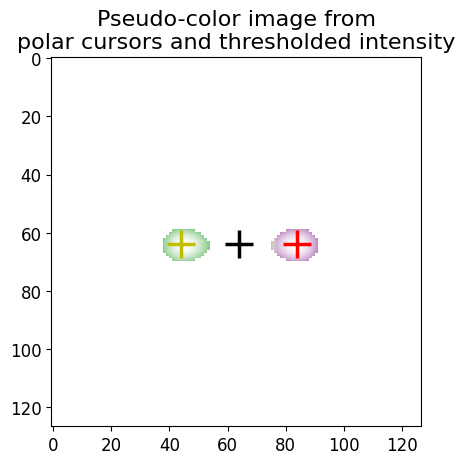

In [23]:
# Polar cursors are used to select regions of interest in the phasor plot based on phase and modulation thresholds.
# Real and Imaginary matrices from which to calculate phasors
real = real_th_spa
imag = imag_th_spa
intensity = mean_th_spa  # Mean intensity map for pseudo-coloring

# Phase and Modulation limits for polar cursors
phase_min      = [0.78, 0, 0.453]
phase_max      = [1.13, 0, 0.555]
modulation_min = [0.438, 0, 0.77]
modulation_max = [0.568, 0, 0.905]

# Plotting parameters
line = 2.5
color = 'Blues'
bins = 80
titlesize = 20
suptitle = 22
axsize = 18
ticksize = 16
legsize = 16
s = 400  # Marker size for scatter plots
color_1, color_2, color_3 = 'y', 'k', 'r'

# Generate mask based on polar cursor thresholds
polar_mask = mask_from_polar_cursor(
    real, imag, phase_min, phase_max, modulation_min, modulation_max
)

# Create phasor plot and overlay polar cursors
plot = PhasorPlot(allquadrants=False, title='Phasor plot with polar cursors')
plot.hist2d(real, imag, cmap=color, bins=bins)
for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=CATEGORICAL[i + 2],
        linestyle='-', linewidth=line
    )
format_plot(plot.ax)
plot.show()

# Generate pseudo-color image from polar mask and intensity map
pseudo_color_MS = pseudo_color(*polar_mask, intensity=intensity, colors=CATEGORICAL[2:])

# Display pseudo-color image
fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_MS)
ax.scatter(cx_1, center, color=color_1, linewidth=2.5, marker='+', s=s)
ax.scatter(center, center, color=color_2, linewidth=2.5, marker='+', s=s)
ax.scatter(cx_2, center, color=color_3, linewidth=2.5, marker='+', s=s)
format_plot(ax)
plt.show()


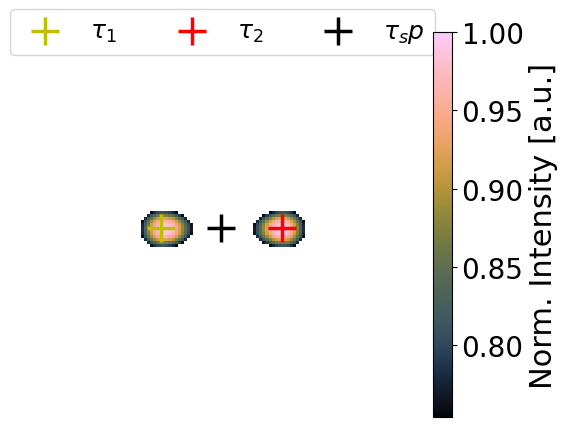

In [24]:
fig = mean_th_spa  # Image to be plotted
x_1 = cx_1
x_2 = cx_2
title = 'Intensity'
barlabel = 'Norm. Intensity [a.u.]'
titlesize = 25
s = 400  # Marker size
legend = 18
axsize = 22
ticksize = 20
labels = ['0.0σ', '1.6σ', '2.0σ', '2.5σ', '3.0σ', '4.0σ', '6.0σ', "Dip"]
color = 'cmc.batlowK'  # Color map

# Plot intensity map
plt.figure(figsize=(7, 5))
im = plt.imshow(fig, cmap=color)

# Overlay markers at selected positions
plt.scatter(x_1, center, color='y', linewidth=2.5, marker='+', s=s, label='$\\tau_1$')
plt.scatter(x_2, center, color='r', linewidth=2.5, marker='+', s=s, label='$\\tau_2$')
plt.scatter(center, center, color='k', linewidth=2.5, marker='+', s=s, label='$\\tau_sp$')

# Add colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label(barlabel, fontsize=axsize)
cbar.ax.tick_params(labelsize=ticksize)

# Hide axes and add legend
plt.axis('off')
plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1), loc='center', fontsize=legend)

format_plot(plt.gca())
plt.show()


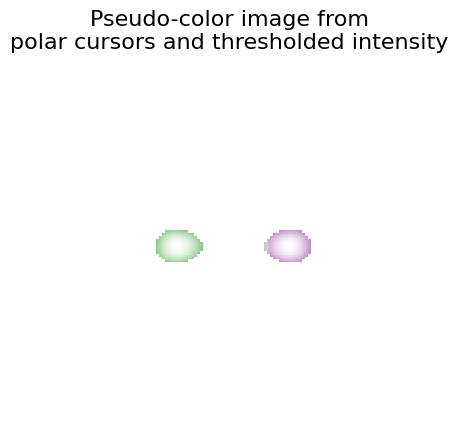

In [25]:
#Simpler version of the previous pseudo-color plot, showing only the masked regions from the polar cursors.
pseudo_color_MS = pseudo_color(*polar_mask, intensity=intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_MS)
plt.axis('off')

format_plot(ax)
plt.show()

### Lifetimes at Different Sigma Positions

Calculate positions for two fluorophores along a line at different sigma distances (from the center of a point spread function).

* *center* is the image center.
* *sigma_px* is the standard deviation of the Gaussian PSF in pixels.
* *Positions* are calculated for diffraction-limited (MS, Sparrow, Rayleigh) and non-diffraction-limited separations (3σ, 4σ, 6σ).
* *sigmas* lists the different separation values to be analyzed for lifetime measurements.

In [26]:
import numpy as np
import scipy.signal

# Mapping distance names to sigma_px multipliers
DISTANCE_MAP = {
    "0s": 0.0,       # Both fluorophores at the center
    "MS": 0.8,       # Minimum separation (MSSR limit)
    "spa": 1.0,      # Sparrow limit
    "ray": 1.25,     # Rayleigh limit
    "3s": 1.5,       # 3-sigma
    "4s": 2.0,       # 4-sigma
    "6s": 3.0        # 6-sigma
}

def process_flim_signal_by_distance_name(signal, PSF, center, cy, sigma_px, distance_name,
                                         y_dim, x_dim, t_dim,
                                         phasor_from_signal, mssr_instance, phasor_threshold,
                                         laser_period_in_seconds, fwhm, amp, order, mesh, ftI, intNorm,
                                         mod_lower_limit, phase_lower_limit,
                                         factor_tm, factor_tp, color):
    """
    Process a FLIM signal with two fluorophores separated by a named distance.

    Parameters:
        signal (np.ndarray): 2D array (t_dim x 2) of fluorophore signals.
        PSF (np.ndarray): Point spread function for convolution.
        center (int): Central x-coordinate of the field.
        cy (int): y-coordinate for the fluorophores.
        sigma_px (float): Pixel size standard deviation for distance scaling.
        distance_name (str): One of ["0s", "MS", "spa", "ray", "3s", "4s", "6s"].
        y_dim, x_dim, t_dim (int): Dimensions of the FLIM stack.
        phasor_from_signal (callable): Function to compute phasor from signal.
        mssr_instance (object): MSSR class instance with sfMSSR method.
        phasor_threshold (callable): Function to threshold phasor images.
        laser_period_in_seconds (float)
        fwhm, amp, order, mesh, ftI, intNorm: MSSR parameters.
        mod_lower_limit, phase_lower_limit (float)
        factor_tm, factor_tp (float)
        color (tuple)

    Returns:
        tuple: mod_th, tau_m_th, phase_th, tau_p_th, mean_th, real_th, imag_th
    """

    if distance_name not in DISTANCE_MAP:
        raise ValueError(f"distance_name must be one of {list(DISTANCE_MAP.keys())}")

    # ----------------------
    # Step 1: Define fluorophore positions
    # ----------------------
    distance_factor = DISTANCE_MAP[distance_name]
    cx_1 = int(center - distance_factor * sigma_px)
    cx_2 = int(center + distance_factor * sigma_px)

    # ----------------------
    # Step 2: Create FLIM stacks
    # ----------------------
    F1xy = np.zeros((y_dim, x_dim, t_dim))
    F2xy = np.zeros((y_dim, x_dim, t_dim))
    F1xy[cy, cx_1, :] = signal.T[:, 1]  # Left fluorophore
    F2xy[cy, cx_2, :] = signal.T[:, 0]  # Right fluorophore

    # ----------------------
    # Step 3: Convolve each frame with PSF
    # ----------------------
    F1xy_convolved = np.empty_like(F1xy)
    F2xy_convolved = np.empty_like(F2xy)
    for t in range(t_dim):
        F1xy_convolved[:, :, t] = scipy.signal.fftconvolve(F1xy[:, :, t], PSF, mode='same')
        F2xy_convolved[:, :, t] = scipy.signal.fftconvolve(F2xy[:, :, t], PSF, mode='same')

    TD_FLIM_signal = F1xy_convolved + F2xy_convolved
    mean_df, real_df, imag_df = phasor_from_signal(TD_FLIM_signal, axis = 2)

    if (distance_name == "MS"):
        mean_df = mssr_instance.sfMSSR(img=mean_df, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
        print("MS")


    mean_th_df, real_th_df, imag_th_df = phasor_threshold(mean_df, real_df, imag_df, mean_min=0.75)

    mod_th_df, tau_m_th_df, phase_th_df, tau_p_th_df, _, _, f = td_flim_figure(
        real_th_df, imag_th_df,
        laser_period_in_seconds,
        harmonic=1,
        mod_correction=False,
        mod_lower_limit=mod_lower_limit,
        phase_correction=False,
        phase_lower_limit=phase_lower_limit,
        tau_m_correction=False,
        factor_tm=factor_tm,
        tau_p_correction=False,
        factor_tp=factor_tp,
        num_bins=30,
        color=color,
        plotit = False
    )

    return mod_th_df, tau_m_th_df, phase_th_df, tau_p_th_df, mean_th_df, real_th_df, imag_th_df


In [27]:
# TD-FLIM for 0
mod_th_0s, tau_m_th_0s, phase_th_0s, tau_p_th_0s, mean_th_0s, real_th_0s, imag_th_0s = process_flim_signal_by_distance_name(
    signal, PSF, center, cy, sigma_px, distance_name="0s",
    y_dim=y_dim, x_dim=x_dim, t_dim=t_dim,
    phasor_from_signal=phasor_from_signal,
    mssr_instance=mssr_instance,
    phasor_threshold=phasor_threshold,
    laser_period_in_seconds=laser_period_in_seconds,
    fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm,
    mod_lower_limit=mod_lower_limit, phase_lower_limit=phase_lower_limit,
    factor_tm=factor_tm, factor_tp=factor_tp, color=color
)

# TD-FLIM for MS
mod_th_MS, tau_m_th_MS, phase_th_MS, tau_p_th_MS, mean_th_MS, real_th_MS, imag_th_MS = process_flim_signal_by_distance_name(
    signal, PSF, center, cy, sigma_px, distance_name="MS",
    y_dim=y_dim, x_dim=x_dim, t_dim=t_dim,
    phasor_from_signal=phasor_from_signal,
    mssr_instance=mssr_instance,
    phasor_threshold=phasor_threshold,
    laser_period_in_seconds=laser_period_in_seconds,
    fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm,
    mod_lower_limit=mod_lower_limit, phase_lower_limit=phase_lower_limit,
    factor_tm=factor_tm, factor_tp=factor_tp, color=color
)

# TD-FLIM for rayleigh
mod_th_ray, tau_m_th_ray, phase_th_ray, tau_p_th_ray, mean_th_ray, real_th_ray, imag_th_ray = process_flim_signal_by_distance_name(
    signal, PSF, center, cy, sigma_px, distance_name="ray",
    y_dim=y_dim, x_dim=x_dim, t_dim=t_dim,
    phasor_from_signal=phasor_from_signal,
    mssr_instance=mssr_instance,
    phasor_threshold=phasor_threshold,
    laser_period_in_seconds=laser_period_in_seconds,
    fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm,
    mod_lower_limit=mod_lower_limit, phase_lower_limit=phase_lower_limit,
    factor_tm=factor_tm, factor_tp=factor_tp, color=color
)

# TD-FLIM for 3 sigmas
mod_th_3s, tau_m_th_3s, phase_th_3s, tau_p_th_3s, mean_th_3s, real_th_3s, imag_th_3s = process_flim_signal_by_distance_name(
    signal, PSF, center, cy, sigma_px, distance_name="3s",
    y_dim=y_dim, x_dim=x_dim, t_dim=t_dim,
    phasor_from_signal=phasor_from_signal,
    mssr_instance=mssr_instance,
    phasor_threshold=phasor_threshold,
    laser_period_in_seconds=laser_period_in_seconds,
    fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm,
    mod_lower_limit=mod_lower_limit, phase_lower_limit=phase_lower_limit,
    factor_tm=factor_tm, factor_tp=factor_tp, color=color
)

# TD-FLIM for 4 sigmas
mod_th_4s, tau_m_th_4s, phase_th_4s, tau_p_th_4s, mean_th_4s, real_th_4s, imag_th_4s = process_flim_signal_by_distance_name(
    signal, PSF, center, cy, sigma_px, distance_name="4s",
    y_dim=y_dim, x_dim=x_dim, t_dim=t_dim,
    phasor_from_signal=phasor_from_signal,
    mssr_instance=mssr_instance,
    phasor_threshold=phasor_threshold,
    laser_period_in_seconds=laser_period_in_seconds,
    fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm,
    mod_lower_limit=mod_lower_limit, phase_lower_limit=phase_lower_limit,
    factor_tm=factor_tm, factor_tp=factor_tp, color=color
)

# TD-FLIM for 6 sigmas
mod_th_6s, tau_m_th_6s, phase_th_6s, tau_p_th_6s, mean_th_6s, real_th_6s, imag_th_6s = process_flim_signal_by_distance_name(
    signal, PSF, center, cy, sigma_px, distance_name="6s",
    y_dim=y_dim, x_dim=x_dim, t_dim=t_dim,
    phasor_from_signal=phasor_from_signal,
    mssr_instance=mssr_instance,
    phasor_threshold=phasor_threshold,
    laser_period_in_seconds=laser_period_in_seconds,
    fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm,
    mod_lower_limit=mod_lower_limit, phase_lower_limit=phase_lower_limit,
    factor_tm=factor_tm, factor_tp=factor_tp, color=color
)

progress: 100%|██████████| 49/49 [00:00<00:00, 67.64it/s]


MS


In [28]:
# Define positions for two fluorophores at different sigma distances
# Both fluorophores initially at the center of the image/grid
cx_1_0s = center  # Fluorophore 1
cx_2_0s = center  # Fluorophore 2

# Define positions for different resolution limits using sigma_px
cx_1_MS  = int(center - 0.8 * sigma_px)   # MS (minimum separation) limit for fluorophore 1
cx_2_MS  = int(center + 0.8 * sigma_px)   # MS limit for fluorophore 2

cx_1_spa = center - sigma_px              # Sparrow limit for fluorophore 1
cx_2_spa = center + sigma_px              # Sparrow limit for fluorophore 2

cx_1_ray = int(center - 1.25 * sigma_px)  # Rayleigh limit for fluorophore 1
cx_2_ray = int(center + 1.25 * sigma_px)  # Rayleigh limit for fluorophore 2

cx_1_3s  = int(center - 1.5 * sigma_px)   # 3-sigma no diffraction limit for fluorophore 1
cx_2_3s  = int(center + 1.5 * sigma_px)   # 3-sigma for fluorophore 2

cx_1_4s  = int(center - 2 * sigma_px)     # 4-sigma no diffraction limit for fluorophore 1
cx_2_4s  = int(center + 2 * sigma_px)     # 4-sigma for fluorophore 2

cx_1_6s  = int(center - 3 * sigma_px)     # 6-sigma no diffraction limit for fluorophore 1
cx_2_6s  = int(center + 3 * sigma_px)     # 6-sigma for fluorophore 2

# Array of sigma values to be used for plotting or reference
sigmas = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


In [29]:
#Indices

index_tm1_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 1.0)
index_tm1_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 1.0)
index_tm1_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 1.0)
index_tm1_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 1.0)
index_tm1_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 1.0)
index_tm1_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 1.0)
index_tm2_MS = np.argwhere(np.round(tau_m_th_MS[center,:]) == 4.0)
index_tm2_spa = np.argwhere(np.round(tau_m_th_spa[center,:]) == 4.0)
index_tm2_ray = np.argwhere(np.round(tau_m_th_ray[center,:]) == 4.0)
index_tm2_3s = np.argwhere(np.round(tau_m_th_3s[center,:]) == 4.0)
index_tm2_4s = np.argwhere(np.round(tau_m_th_4s[center,:]) == 4.0)
index_tm2_6s = np.argwhere(np.round(tau_m_th_6s[center,:]) == 4.0)

index_tp1_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 1.0)
index_tp1_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 1.0)
index_tp1_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 1.0)
index_tp1_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 1.0)
index_tp1_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 1.0)
index_tp1_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 1.0)
index_tp2_MS = np.argwhere(np.round(tau_p_th_MS[center,:]) == 4.0)
index_tp2_spa = np.argwhere(np.round(tau_p_th_spa[center,:]) == 4.0)
index_tp2_ray = np.argwhere(np.round(tau_p_th_ray[center,:]) == 4.0)
index_tp2_3s = np.argwhere(np.round(tau_p_th_3s[center,:]) == 4.0)
index_tp2_4s = np.argwhere(np.round(tau_p_th_4s[center,:]) == 4.0)
index_tp2_6s = np.argwhere(np.round(tau_p_th_6s[center,:]) == 4.0)

def safe_extract_index(arr, i=0, default=None):
    """
    Safely extract an integer index from a np.argwhere output.
    If the array is empty, returns 'default'.
    """
    if arr.size > 0:
        return int(arr[i][0])
    else:
        if default is None:
            raise ValueError("Index array is empty and no default provided")
        return int(default)

# Extracting Lifetimes from the new centroid of each fluorophore
# Fluorophore 1 (left)
LTm_1 = [
    tau_m_th_0s[center, cx_1_0s],
    tau_m_th_MS[center, safe_extract_index(index_tm1_MS, default=cx_1_MS)],
    tau_m_th_spa[center, safe_extract_index(index_tm1_spa, default=cx_1_spa)],
    tau_m_th_ray[center, safe_extract_index(index_tm1_ray, default=cx_1_ray)],
    round(tau_m_th_3s[center, cx_1_3s]),
    round(tau_m_th_4s[center, cx_1_4s]),
    round(tau_m_th_6s[center, cx_1_6s])
]

# Fluorophore 2 (right)
LTm_2 = [
    tau_m_th_0s[center, cx_2_0s],
    tau_m_th_MS[center, safe_extract_index(index_tm2_MS, -1, default=cx_2_MS)],
    tau_m_th_spa[center, safe_extract_index(index_tm2_spa, -1, default=cx_2_spa)],
    tau_m_th_ray[center, safe_extract_index(index_tm2_ray, -1, default=cx_2_ray)],
    round(tau_m_th_3s[center, cx_2_3s]),
    round(tau_m_th_4s[center, cx_2_4s]),
    round(tau_m_th_6s[center, cx_2_6s])
]

# Fluorophore 1 (phase)
LTp_1 = [
    tau_p_th_0s[center, cx_1_0s],
    tau_p_th_MS[center, safe_extract_index(index_tp1_MS, default=cx_1_MS)],
    tau_p_th_spa[center, safe_extract_index(index_tp1_spa, default=cx_1_spa)],
    tau_p_th_ray[center, safe_extract_index(index_tp1_ray, default=cx_1_ray)],
    round(tau_p_th_3s[center, cx_1_3s]),
    round(tau_p_th_4s[center, cx_1_4s]),
    round(tau_p_th_6s[center, cx_1_6s])
]

# Fluorophore 2 (phase)
LTp_2 = [
    tau_p_th_0s[center, cx_2_0s],
    tau_p_th_MS[center, safe_extract_index(index_tp2_MS, -1, default=cx_2_MS)],
    tau_p_th_spa[center, safe_extract_index(index_tp2_spa, -1, default=cx_2_spa)],
    tau_p_th_ray[center, safe_extract_index(index_tp2_ray, -1, default=cx_2_ray)],
    round(tau_p_th_3s[center, cx_2_3s]),
    round(tau_p_th_4s[center, cx_2_4s]),
    round(tau_p_th_6s[center, cx_2_6s])
]

LTm_sp = [
    tau_m_th_0s[center, center], tau_m_th_MS[center, center],
    tau_m_th_spa[center, center], tau_m_th_ray[center,center],
    tau_m_th_3s[center,center], tau_m_th_4s[center,center],
    round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))
    ]

LTp_sp = [
    tau_p_th_0s[center, center], tau_p_th_MS[center, center],
    tau_p_th_spa[center, center], tau_p_th_ray[center,center],
    tau_p_th_3s[center,center], tau_p_th_4s[center,center],
    round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))
    ]

# Lifetimes from each center cx_i

LTm_1_c = [tau_m_th_0s[center, cx_1_0s] ,tau_m_th_MS[center, cx_1_MS], tau_m_th_spa[center, cx_1_spa], tau_m_th_ray[center,cx_1_ray], round(tau_m_th_3s[center,cx_1_3s]), round(tau_m_th_4s[center,cx_1_4s]), round(tau_m_th_6s[center,cx_1_6s])]
LTm_2_c = [tau_m_th_0s[center, cx_2_0s] ,tau_m_th_MS[center, cx_2_MS], tau_m_th_spa[center, cx_2_spa], tau_m_th_ray[center,cx_2_ray], round(tau_m_th_3s[center,cx_2_3s]), round(tau_m_th_4s[center,cx_2_4s]), round(tau_m_th_6s[center,cx_2_6s])]
LTp_1_c = [tau_p_th_0s[center, cx_1_0s] ,tau_p_th_MS[center, cx_1_MS], tau_p_th_spa[center, cx_1_spa], tau_p_th_ray[center,cx_1_ray], round(tau_p_th_3s[center,cx_1_3s]), round(tau_p_th_4s[center,cx_1_4s]), round(tau_p_th_6s[center,cx_1_6s])]
LTp_2_c = [tau_p_th_0s[center, cx_2_0s] ,tau_p_th_MS[center, cx_2_MS], tau_p_th_spa[center, cx_2_spa], tau_p_th_ray[center,cx_2_ray], round(tau_p_th_3s[center,cx_2_3s]), round(tau_p_th_4s[center,cx_2_4s]), round(tau_p_th_6s[center,cx_2_6s])]
LTm_sp_c = [tau_m_th_0s[center, center] ,tau_m_th_MS[center, center], tau_m_th_spa[center, center], tau_m_th_ray[center,center], tau_m_th_3s[center,center], tau_m_th_4s[center,center], round(np.nan_to_num(tau_m_th_6s[center,center], nan=0))]
LTp_sp_c = [tau_p_th_0s[center, center] ,tau_p_th_MS[center, center], tau_p_th_spa[center, center], tau_p_th_ray[center,center], tau_p_th_3s[center,center], tau_p_th_4s[center,center], round(np.nan_to_num(tau_p_th_6s[center,center], nan=0))]


### Modulation Lifetime Analysis
We plot the extracted Modulation Lifetimes ($\tau_M$) as a function of the separation distance between the two fluorophores (expressed in units of the PSF size, $\sigma$).
Plot Components:
* Scatter Points: Recovered lifetimes at the peak positions of Fluorophore 1 ($\tau_{M,1}$) and Fluorophore 2 ($\tau_{M,2}$), and at the geometric center ($\tau_{M,sp}$, the saddle point).
* Dashed Lines: Theoretical ground truth values for $\tau_1$ (1.0 ns), $\tau_2$ (4.0 ns), and the theoretical mixture at the saddle point.

**Interpretation:**
* Large Separation ($> 3\sigma$): The recovered lifetimes match the ground truth (points align with dashed lines).
* Small Separation ($< 2\sigma$): The recovered lifetimes deviate significantly due to spatial mixing induced by the PSF convolution.

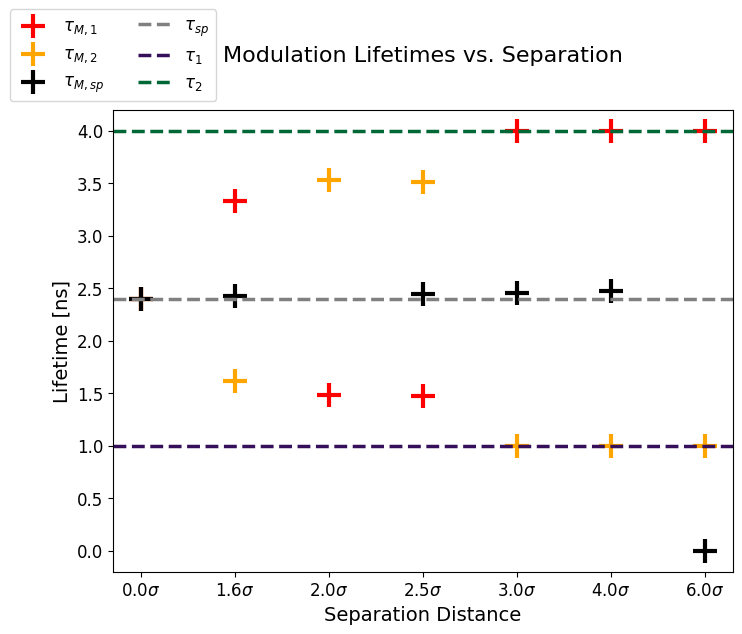

In [30]:
# Plotting Parameters
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
legend = 12

#Labels for the x-axis (Sigma values)
x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]
labels =['0.0$\u03c3$', '1.6$\u03c3$','2.0$\u03c3$', '2.5$\u03c3$', '3.0$\u03c3$','4.0$\u03c3$', '6.0$\u03c3$', "Dip"]
plt.figure(figsize=(8, 6))

# Scatter Plots of Recovered Lifetimes
# Plot Tau_M1 (recovered lifetime of Fluorophore 1)
plt.scatter(sigmas, LTm_1, linewidth=line, marker='+', color='r', s=s, label='$\u03c4_{M,1}$')

#Plot Tau_M2 (recovered lifetime of Fluorophore 2)
plt.scatter(sigmas, LTm_2, linewidth=line, marker='+', color='orange', s=s, label='$\u03c4_{M,2}$')

#Plot Tau_M_sp (recovered lifetime at the Center)
plt.scatter(sigmas, LTm_sp, linewidth=line, marker='+', color='k', s=s, label='$\u03c4_{M,sp}$')

#Reference Lines (Ground Truth)
# Theoretical Saddle Point value (from 0s simulation)
plt.axhline(tau_m_th_0s[center, center], linestyle="--", linewidth=refline, color="gray", label='$\u03c4_{sp}$')

#Theoretical Tau 1 (1.0 ns)
plt.axhline(1, linestyle="--", linewidth=refline, color="#360f5a", label="$\u03c4_1$")
#Theoretical Tau 2 (4.0 ns)
plt.axhline(4, linestyle="--", linewidth=refline, color="#006837", label="$\u03c4_2$")

plt.title('Modulation Lifetimes vs. Separation', fontsize=title, pad=35)
plt.xlabel('Separation Distance', fontsize=axis_labels)
plt.ylabel('Lifetime [ns]', fontsize=axis_labels)
# Set x-ticks to correspond to the simulated sigma values
plt.xticks(sigmas, labels=xlabels, fontsize=ticks)
plt.yticks(fontsize=ticks)
# Legend positioning
plt.legend(ncols=2, bbox_to_anchor=(-0, 1), loc='lower center', fontsize=legend)

format_plot(plt.gca())
plt.show()

### Phase Lifetime Analysis

We generate the corresponding plot for Phase Lifetimes ($\tau_\phi$). This allows us to compare how the phase-derived lifetime varies with spatial resolution compared to the modulation-derived lifetime.
Plot Components:
* Scatter Points: Recovered $\tau_\phi$ at the peak positions of Fluorophore 1 ($\tau_{\phi,1}$), Fluorophore 2 ($\tau_{\phi,2}$), and the saddle point ($\tau_{\phi,sp}$).
* Dashed Lines: Ground truth values.

Observation:
Ideally, $\tau_\phi$ and $\tau_M$ should yield similar trends. Divergences between them in experimental data can indicate complex decay kinetics (multi-exponential) or other artifacts, but here they primarily show the mixing effect of the PSF.

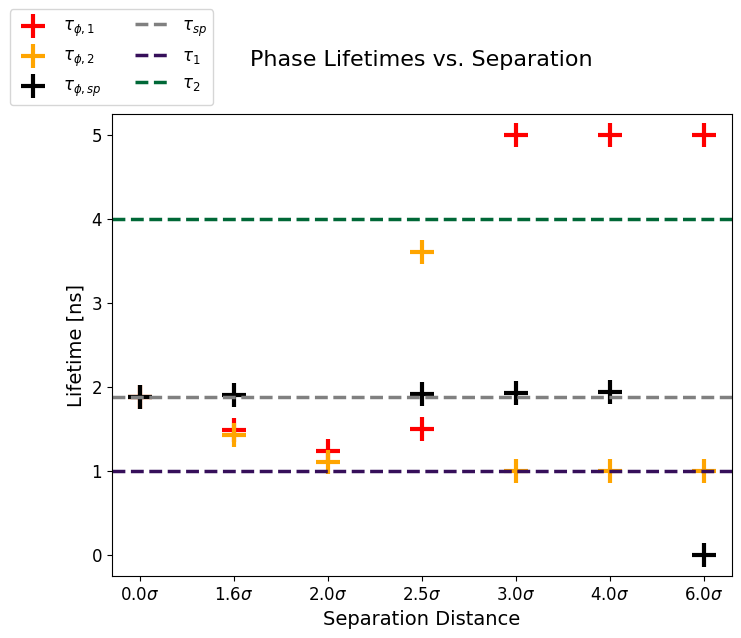

In [31]:
# Plotting Parameters
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
legend = 12

# Labels for x-axis (Sigma values)
x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

# Legend labels (for reference, not all used in final legend)
labels = ['0.0$\u03c3$', '1.6$\u03c3$', '2.0$\u03c3$', '2.5$\u03c3$',
          '3.0$\u03c3$', '4.0$\u03c3$', '6.0$\u03c3$', "Dip"]

plt.figure(figsize=(8, 6))

# Scatter Plots of Recovered Phase Lifetimes
# Plot Tau_Phi1 (Fluorophore 1)
plt.scatter(sigmas, LTp_1, linewidth=line, marker='+', color='r', s=s, label='$\u03c4_{\u03D5,1}$')

# Plot Tau_Phi2 (Fluorophore 2)
plt.scatter(sigmas, LTp_2, linewidth=line, marker='+', color='orange', s=s, label='$\u03c4_{\u03D5,2}$')

# Plot Tau_Phi_sp (Saddle Point)
plt.scatter(sigmas, LTp_sp, linewidth=line, marker='+', color='k', s=s, label='$\u03c4_{\u03D5,sp}$')

# Reference Lines (Ground Truth)
# Theoretical Saddle Point
plt.axhline(tau_p_th_0s[center, center], linestyle="--", linewidth=refline, color="gray", label='$\u03c4_{sp}$')

# Theoretical Tau 1
plt.axhline(1, linestyle="--", linewidth=refline, color="#360f5a", label="$\u03c4_1$")

# Theoretical Tau 2
plt.axhline(4, linestyle="--", linewidth=refline, color="#006837", label="$\u03c4_2$")

# Formatting
plt.title('Phase Lifetimes vs. Separation', fontsize=title, pad=35)
plt.xlabel('Separation Distance', fontsize=axis_labels)
plt.ylabel('Lifetime [ns]', fontsize=axis_labels)

# Set x-ticks and y-ticks
plt.xticks(sigmas, labels=xlabels, fontsize=ticks)
plt.yticks(fontsize=ticks)

# Legend positioning
plt.legend(ncols=2, bbox_to_anchor=(-0, 1), loc='lower center', fontsize=legend)

format_plot(plt.gca())

plt.show()


### Modulation Lifetime Analysis (Theoretical Centers)

We plot the Modulation Lifetimes ($\tau_M$) extracted specifically at the theoretical geometric centers ($cx_1, cx_2$) of the fluorophores, regardless of any apparent spatial shift in intensity.

Key Comparison:Unlike the previous search-based extraction, this fixed-coordinate analysis shows exactly how much the lifetime "at the pixel where the molecule exists" is contaminated by the blurring of the neighboring fluorophore.
* $\tau_{M,1}$ (Red): Lifetime at the coordinate of Fluorophore 1.
* $\tau_{M,2}$ (Orange): Lifetime at the coordinate of Fluorophore 2.
* $\tau_{M,sp}$ (Black): Lifetime at the saddle point (midpoint).

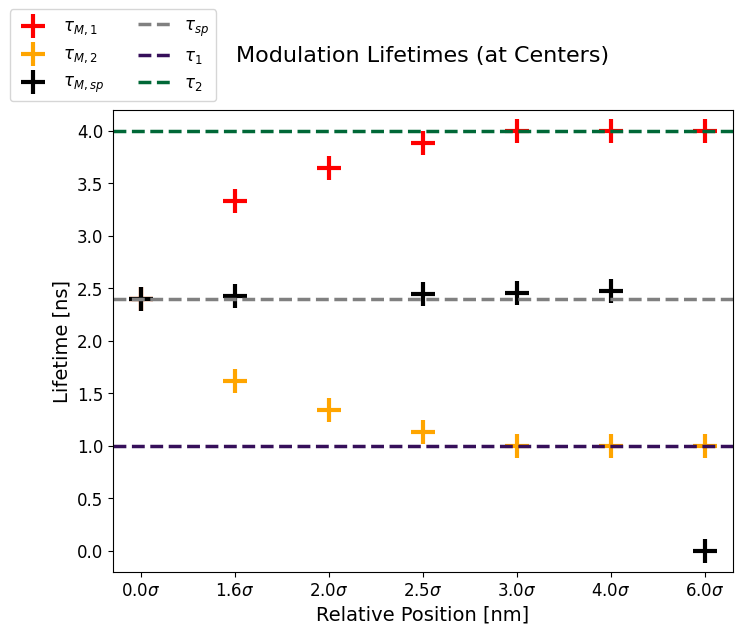

In [32]:
# Plotting Parameters
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
legend = 12

# Labels for legend
labels = ['0.0$\u03c3$', '1.6$\u03c3$', '2.0$\u03c3$', '2.5$\u03c3$',
          '3.0$\u03c3$', '4.0$\u03c3$', '6.0$\u03c3$', "Dip"]

# X-axis configuration (Sigma values)
x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.figure(figsize=(8, 6))

# Scatter Plots (Theoretical Centers)
# Plot Tau_M1 extracted at cx_1 (Fluorophore 1)
plt.scatter(sigmas, LTm_1_c, linewidth=line, marker='+', color='r', s=s, label='$\u03c4_{M,1}$')

# Plot Tau_M2 extracted at cx_2 (Fluorophore 2)
plt.scatter(sigmas, LTm_2_c, linewidth=line, marker='+', color='orange', s=s, label='$\u03c4_{M,2}$')

# Plot Tau_M_sp extracted at center (Saddle point)
# Note: Ensure LTm_sp_c is defined in your aggregation step
plt.scatter(sigmas, LTm_sp_c, linewidth=line, marker='+', color='k', s=s, label='$\u03c4_{M,sp}$')

# Reference Lines (Ground Truth)
# Theoretical Saddle Point
plt.axhline(tau_m_th_0s[center, center], linestyle="--", linewidth=refline, color="gray", label='$\u03c4_{sp}$')

# Theoretical Tau 1 (1.0 ns)
plt.axhline(1, linestyle="--", linewidth=refline, color="#360f5a", label="$\u03c4_1$")

# Theoretical Tau 2 (4.0 ns)
plt.axhline(4, linestyle="--", linewidth=refline, color="#006837", label="$\u03c4_2$")

# Formatting
plt.title('Modulation Lifetimes (at Centers)', fontsize=title, pad=35)
plt.xlabel('Relative Position [nm]', fontsize=axis_labels)
plt.ylabel('Lifetime [ns]', fontsize=axis_labels)

# Set x-ticks and y-ticks
plt.xticks(sigmas, labels=xlabels, fontsize=ticks)
plt.yticks(fontsize=ticks)

# Legend
plt.legend(ncols=2, bbox_to_anchor=(0, 1), loc='lower center', fontsize=legend)

format_plot(plt.gca())
plt.show()


### Phase Lifetime Analysis (Theoretical Centers)

We generate the corresponding plot for Phase Lifetimes ($\tau_\phi$) extracted at the theoretical geometric centers.
Comparisons:
* Consistency: We check if the phase lifetime ($\tau_\phi$) degrades in the same way as the modulation lifetime ($\tau_M$) as the separation distance decreases.
* Mixing Behavior: At $\sigma=0$ (complete overlap), both $\tau_{\phi,1}$ and $\tau_{\phi,2}$ should converge to the saddle point value ($\tau_{\phi,sp}$), effectively measuring the lifetime of the 50:50 mixture.

Key Variables:
* LTp_1_c, LTp_2_c: Phase lifetimes at the fixed coordinates of the fluorophores.
* LTp_sp_c: Phase lifetime at the fixed center coordinate.

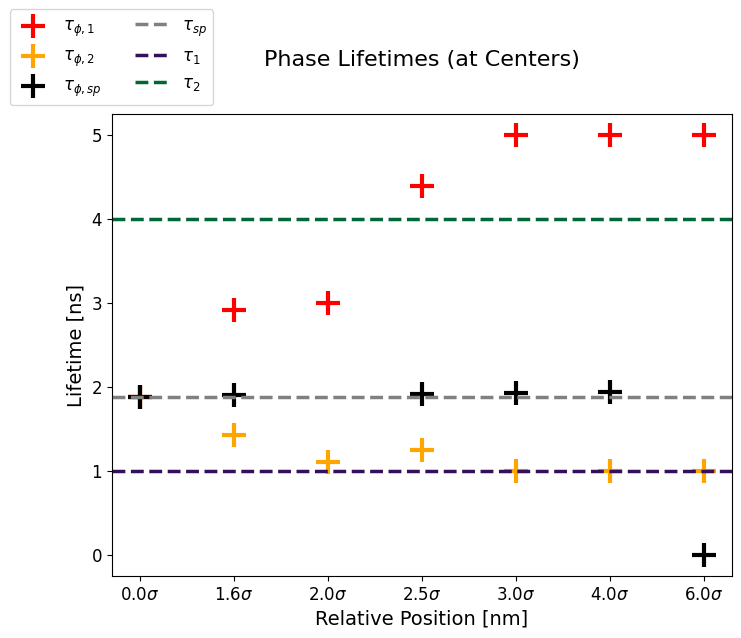

In [33]:
# Plotting Parameters
axis_labels = 12
title = 16
ticks = 12
line = 3.0
refline = 2.5
s = 300
legend = 12

# Labels for the x-axis (Sigma values)
labels = ['0.0$\u03c3$', '1.6$\u03c3$', '2.0$\u03c3$', '2.5$\u03c3$',
          '3.0$\u03c3$', '4.0$\u03c3$', '6.0$\u03c3$', "Dip"]

x_ticks = [0, 1.6, 2.0, 2.5, 3.0, 4.0, 6.0]
xlabels = [f'{x:1.1f}$\u03c3$' for x in x_ticks]

plt.figure(figsize=(8, 6))

# Scatter Plots (Theoretical Centers)
# Plot Tau_Phi1 extracted at cx_1 (Fluorophore 1, Fixed center)
plt.scatter(sigmas, LTp_1_c, linewidth=line, marker='+', color='r', s=s, label='$\u03c4_{\u03D5,1}$')

# Plot Tau_Phi2 extracted at cx_2 (Fluorophore 2, Fixed center)
plt.scatter(sigmas, LTp_2_c, linewidth=line, marker='+', color='orange', s=s, label='$\u03c4_{\u03D5,2}$')

# Plot Tau_Phi_sp extracted at center (Saddle point)
plt.scatter(sigmas, LTp_sp_c, linewidth=line, marker='+', color='k', s=s, label='$\u03c4_{\u03D5,sp}$')

# Reference Lines (Ground Truth)
# Theoretical Saddle Point
plt.axhline(tau_p_th_0s[center, center], linestyle="--", linewidth=refline, color="gray", label='$\u03c4_{sp}$')

# Theoretical Tau 1 (1.0 ns)
plt.axhline(1, linestyle="--", linewidth=refline, color="#360f5a", label="$\u03c4_1$")

# Theoretical Tau 2 (4.0 ns)
plt.axhline(4, linestyle="--", linewidth=refline, color="#006837", label="$\u03c4_2$")

plt.title('Phase Lifetimes (at Centers)', fontsize=title, pad=35)
plt.xlabel('Relative Position [nm]', fontsize=axis_labels)
plt.ylabel('Lifetime [ns]', fontsize=axis_labels)

# Set x-ticks and y-ticks
plt.xticks(sigmas, labels=xlabels, fontsize=ticks)
plt.yticks(fontsize=ticks)

# Legend positioning
plt.legend(ncols=2, bbox_to_anchor=(0, 1), loc='lower center', fontsize=legend)

format_plot(plt.gca())

plt.show()


## Phase Map Visualization (Rayleigh Limit)
We generate a detailed map of the Phase Angle ($\phi$) for the simulation corresponding to the Rayleigh Limit (denoted here as 2.5$\sigma$ in relative distance units).

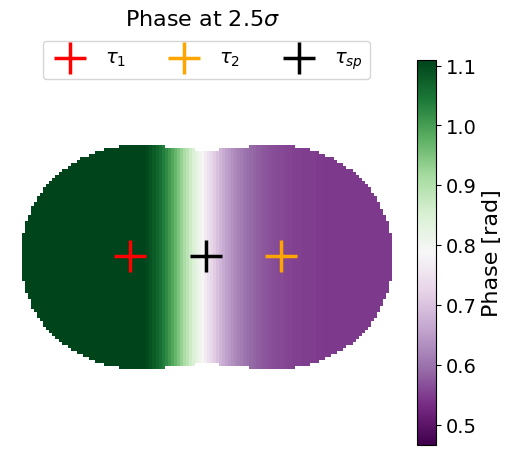

In [34]:
# Data Selection
fig = phase_th_ray        # Phase map for Rayleigh limit (thresholded)
x_1 = cx_1_ray            # Position of Fluorophore 1
x_2 = cx_2_ray            # Position of Fluorophore 2

# Plotting Parameters
title = 'Phase at 2.5$\u03c3$'
barlabel = 'Phase [rad]'
titlesize = 16
s = 500                    # Marker size
legend = 14
axsize = 16
ticksize = 14
color = 'PRGn'             # Colormap (Purple-Green)

# Theoretical Limits for Color Scaling
# Calculate angular frequency
w = (2 * np.pi) / T       # T is the laser period in ns (defined globally)

# Calculate theoretical phase limits
phi_max = np.arctan(w * tau_2)  # Max phase (Longer lifetime)
phi_min = np.arctan(w * tau_1)  # Min phase (Shorter lifetime)

# Note: Modulation limits calculated but not used in this specific plot
mod_min = 1 / np.sqrt(1 + (w * tau_2)**2)
mod_max = 1 / np.sqrt(1 + (w * tau_1)**2)

# Plot Generation
plt.figure(figsize=(7, 5))

# Display Image with theoretical phase limits
im = plt.imshow(fig, cmap=color, vmin=phi_min, vmax=phi_max)

# Markers
# Mark Fluorophore 1 (Tau 1)
plt.scatter(x_1, center, color='r', linewidth=2.5, marker='+', s=s, label='$\u03c4_1$')

# Mark Fluorophore 2 (Tau 2)
plt.scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=s, label='$\u03c4_2$')

# Mark Saddle Point (Center)
plt.scatter(center, center, color='k', linewidth=2.5, marker='+', s=s, label='$\u03c4_{sp}$')

# Formatting
plt.title(title, fontsize=titlesize, pad=25)

# Colorbar configuration
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label(barlabel, fontsize=axsize)
cbar.ax.tick_params(labelsize=ticksize)

# Hide axes for clean image view
plt.axis('off')

# Optional: Legend
plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1), loc='center', fontsize=legend)

plt.show()

## Modulation Lifetime Visualization (MSSR)
We visualize the Modulation Lifetime ($\tau_M$) map obtained after applying the MSSR (Microscopy with Self-Supervised Resolution) algorithm.

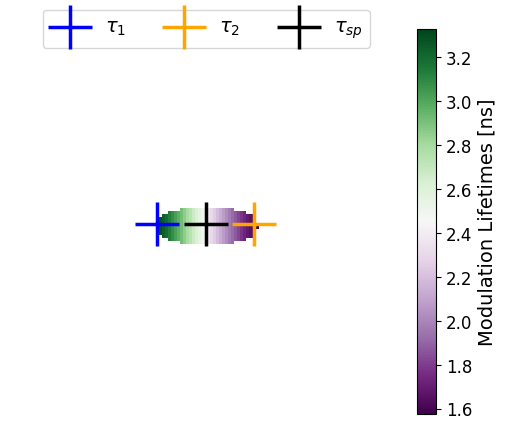

Recovered Lifetime at Tau_2 position: 1.6144 ns


In [35]:
# Data Selection
fig = tau_m_th_MS        # Modulation Lifetime map for MSSR case
x_1 = cx_1_MS            # Position of Fluorophore 1 (MSSR limit)
x_2 = cx_2_MS            # Position of Fluorophore 2 (MSSR limit)

# Plot Generation
plt.figure(figsize=(7, 5))

# Display image using the global colormap
im = plt.imshow(fig, cmap=color)

# Markers
# Mark Fluorophore 1 (Blue)
plt.scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000, label='$\u03c4_1$')

# Mark Fluorophore 2 (Orange)
plt.scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000, label='$\u03c4_2$')

# Mark Saddle Point (Black)
plt.scatter(center, center, color='k', linewidth=2.5, marker='+', s=1000, label='$\u03c4_{sp}$')

# Colorbar configuration
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Modulation Lifetimes [ns]", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Hide axis for clean image
plt.axis('off')

# Optional legen
plt.legend(ncols=len(labels), bbox_to_anchor=(0.51, 1), loc='center', fontsize=legend)

# Show plot
plt.show()

# --- Quantitative Verification ---
# Print the recovered lifetime at Fluorophore 2 position
print(f"Recovered Lifetime at Tau_2 position: {tau_m_th_MS[center, x_2]:.4f} ns")
